## DCGAN with PyTorch

This is a binary classification problem:

* Inputs: Image with one channel and 28×28 pixels in size.
* Outputs: Binary classification, likelihood the sample is real (or fake).



# Fundamental way GAN Works


GAN contains two networks which has two competing objectives:

Generator: the generator generates new data instances that are "similar" to the training data, in our case celebA images. Generator takes random latent vector and output a "fake" image of the same size as our reshaped celebA image.

Discriminator: the discriminator evaluate the authenticity of provided images; it classifies the images from the generator and the original image. Discriminator takes true of fake images and output the probability estimate ranging between 0 and 1.

![Imgur](https://imgur.com/pLJdmxs.png)


### The basic objective function of a vanilla GAN model is the following:

![Imgur](https://imgur.com/LMjhfKk.png)

Here, D refers to the discriminator network, while G obviously refers to the generator.

As the formula shows, the generator optimizes for maximally confusing the discriminator, by trying to make it output high probabilities for fake data samples.

On the contrary, the discriminator tries to become better at distinguishing samples coming from G from samples coming from the real distribution.

The GAN training process consists of a two-player minimax game in which D is adapted to minimize the discrimination error between real and generated samples, and G is adapted to maximize the probability of D making a mistake. When G does a good enough job to fool D, the output probability should be close to 1.

---

## Deep Convolutional GANs (DCGANs)

Deep Convolutional GANs (DCGANs) introduced convolutions to the generator and discriminator networks.

However, this was not simply a matter of adding convolutional layers to the model, since training became even more unstable.

---


### Generator and Discriminator

The Generator’s objective is to learn the data distribution for the training data to produce fake images that resemble the training data.

The Discriminator is a classifier whose objective is to distinguish the real data from the fake data generated by the Generator. Every time the Discriminator detects the fake data generated by the
Generator, then the Generator is penalized.

The Generator and Discriminator are pitted against each other as the Generator tries to fool the Discriminator, and the Discriminator learns not to get fooled by the Generator.

Both Generator and Discriminator are neural networks. Input to the Generator is random noise.

In contrast, the input to the Discriminator is the output from the Generator(which are fake data) considered negative examples, and also the real images from the training data (which are considered positive examples) during training.

The discriminator loss penalizes the Discriminator for misclassifying real data as fake or fake data as real.

## Generator Architecture

![Imgur](https://imgur.com/bHX4suR.png)

The generator network of a DCGAN contains 4 hidden layers (we treat the input layer as
the 1st hidden layer for simplicity) and 1 output layer. Transposed convolution layers are
used in hidden layers, which are followed by batch normalization layers and ReLU
activation functions. The output layer is also a transposed convolution layer and Tanh is
used as the activation function.


## The architecture of a discriminator

![Imgur](https://imgur.com/HQWoKrF.png)

The discriminator network of a DCGAN consists of 4 hidden layers (again, we treat the
input layer as the 1st hidden layer) and 1 output layer. Convolution layers are used in all
layers, which are followed by batch normalization layers except that the first layer does not
have batch normalization. LeakyReLU activation functions are used in the hidden layers
and Sigmoid is used for the output layer. The architecture of the discriminator is shown in
the following:

The input channel can be either 1 or 3, depending on whether you are dealing with
grayscale images or color images. All hidden layers have a stride value of 2 and a padding
value of 1 so that their output image sizes will be half the input images. As image sizes
increase in deeper layers, the numbers of channels are increasing by twice. All kernels in
convolution layers are of a size of 4 x 4. The output layer has a stride value of 1 and a
padding value of 0. It maps 4 x 4 feature maps to single values so that the Sigmoid function
can transform the value into prediction confidence.

- when receiving real images, the discriminator should learn to compute high values (near 1), meaning that it is confident the input images are real

- when receiving fake images, it should compute low values (near 0), meaning it is confident the input images are not real

To accomplish this, we use the binary cross entropy function defined earlier. The generator tries to achieve the opposite goal, it tries to make the discriminator assign high values to fake images.

---


### Several tricks had to be applied to make DCGANs stable and useful:

* Batch normalization was applied to both the generator and the discriminator network
* Dropout is used as a regularization technique
* The generator needed a way to upsample the random input vector to an output image. Transposing convolutional layers is employed here
* LeakyRelu and TanH activations are used throughout both networks

------------------------------------------------------------------------------

# How Reverse ConvNets works in DCGAN

ConvNets have traditionally been used for image classification
tasks, in which the network takes in an image with the
dimensions height × width × number of color channels as
input and—through a series of convolutional layers—outputs a
single vector of class scores, with the dimensions 1 × n, where
n is the number of class labels.

In DCGAN, under the Generator part, to generate an image by using the ConvNet architecture, we reverse the process: instead of taking an image and processing it into a vector, we take a
vector and up-size it to an image.

So, overall, the core to the DCGAN architecture uses a standard CNN architecture on the discriminative model.

But for the generator, convolutions are replaced with up-convolutions, so the representation at each layer of the generator is actually successively larger, as it maps from a low-dimensional latent vector onto a high-dimensional image.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image
from torchsummary import summary

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import itertools
from glob import glob

from google.colab import drive
drive.mount('/content/drive')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device)


Mounted at /content/drive
Using cuda


In [2]:
''' 
torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)

'''

class Generator(nn.Module):
    """
    The Generator takes the noise vector as an input to generate the images that will resemble the training dataset(1,28,28) accomplished through a series of strided two-dimensional ConvTranspose2d layers. The ConvTranspose2d layers are paired with BatchNorm2d layers as they help with the flow of gradients during training, which is followed by a ReLU activation function.
    
    noise_vector:  is the length of the z input vector.
    
    num_gen_filter: size of the feature maps that are propagated through the generator, 
    
    num_ch: The number of channels in the output image (set to 1 for Grayscale images). 
    
    Here, the height and width dimension of the image does not change, only the channel dimension increases.
    
    For the Conv and ConvTranspose layers: 
    * in_channels (int) – Number of channels/filters in the input image
    * out_channels (int) – Number of channels/filters produced by the convolution    
    
    """

    def __init__(self, num_ch, noise_vector, num_gen_filter):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=noise_vector,
                out_channels=num_gen_filter * 4,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(num_gen_filter * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=num_gen_filter * 4,
                out_channels=num_gen_filter * 2,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_gen_filter * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=num_gen_filter * 2,
                out_channels=num_gen_filter,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_gen_filter),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=num_gen_filter,
                out_channels=num_ch,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.Tanh(),
        )

    def forward(self, input):
        output = self.network(input)
        return output


class Discriminator(nn.Module):
    ''' 
    The Discriminator is a binary classification neural network to classify the input as real or fake images of dimension (1,28,28). The inputs to the Discriminator are real images from the training dataset and the fake images generated by the Generator.
    The Discriminator outputs a scalar probability to classify the input image as real or fake.

    torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    Here, the height and width dimension of the image does not change, only the channel dimension increases. 
    '''
    def __init__(self, num_ch, num_disc_filter):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(
                in_channels=num_ch,
                out_channels=num_disc_filter,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=num_disc_filter,
                out_channels=num_disc_filter * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_disc_filter * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=num_disc_filter * 2,
                out_channels=num_disc_filter * 4,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_disc_filter * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                in_channels=num_disc_filter * 4,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Sigmoid(),
        )

    # The Discriminator outputs a scalar probability to classify the input image as real or fake.
    # squeeze removes all superficial 1 dimensions from tensor.
    def forward(self, input):
        ''' forward pass of the discriminator
        Input is an image tensor, 
        returns a 1-dimension tensor representing image as    
        fake/real. '''
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

## why BatchNorm needs to set bias=False in pytorch?

Batchnormalization already includes the addition of the bias term.

BatchNorm learns the mean and stdev of the y vector over many batches, and uses that to recentre and rescale the data (standardisation) and including a bias in previous layer will be cancelled here.

In [4]:
def get_data_loader(batch_size):
    # MNIST Dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307, ), std=(0.3081, ))])

    train_dataset = datasets.MNIST(root="/content/drive/MyDrive/All_Datasets/MNIST", train=True, transform=transform, download=True)

    # Data Loader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

In [5]:
def plot_images(epoch, path, num_test_samples, generator, device):
    z = torch.randn(num_test_samples, 100, 1, 1, device=device)

    plot_grid_size = int(math.sqrt(num_test_samples))

    title = None

    generated_fake_images = generator(z)

    path += "variable_noise/"

    title = "Variable Noise"

    fig, ax = plt.subplots(plot_grid_size, plot_grid_size, figsize=(6, 6))

    for i, j in itertools.product(range(plot_grid_size), range(plot_grid_size)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for sample in range(num_test_samples):
        i = sample // 4
        j = sample % 4
        ax[i, j].cla()
        ax[i, j].imshow(
            generated_fake_images[sample].data.cpu().numpy().reshape(28, 28),
            cmap="Greys",
        )

    label = "Epoch_{}".format(epoch + 1)
    fig.text(0.5, 0.04, label, ha="center")
    fig.suptitle(title)


In [10]:
batch_size = 256

output_path = '/content/sample_data/'

# Gather MNIST Dataset    
train_loader = get_data_loader(batch_size)

# Create the Discriminator and Generator network
discriminator_net = Discriminator(num_ch=1, num_disc_filter=32).to(device)

generator_net = Generator(num_ch=1, noise_vector=100, num_gen_filter=32).to(device)

# loss function
criterion = nn.BCELoss()

# optimizers
optimizerD = optim.Adam(discriminator_net.parameters(), lr=0.001)
optimizerG = optim.Adam(generator_net.parameters(), lr=0.001)

# initialize variables required for training
real_label = 1.0
fake_label = 0.0
# num_batches = len(train_loader)
num_test_samples = 16
fixed_noise = torch.randn(num_test_samples, 100, 1, 1, device=device)
num_epochs = 75
noise_vector = 100

## Final Training

### Part 1 - Train the Discriminator

- First, we will construct a batch of real samples from the training set, forward pass through Discriminator, calculate the loss (log(D(x))), then calculate the gradients in a backward pass.

- Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through Discriminator, calculate the loss (log(1-D(G(z))), and accumulate the gradients with a backward pass. Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator’s optimizer.


### Part 2 - Training Generator

- classifying the Generator output from Part 1 with the Discriminator, computing Generator’s loss using real labels as GT, 

- computing Generator’s gradients in a backward pass, and finally updating Generator’s parameters with an optimizer step. 


===========================================================================

## Training Strategy of DCGAN

* Keep the Generator constant during the Discriminator training phase.

* When training the Generator, we do not want the Discriminator to change else we will be expecting the generator learn a moving target and as a result the Generator will never converge

* Keep the Discriminator constant during the Generator training phase

* When training the Discriminator we do not want the Generator to change as we want the Discriminator to learn how to classify the real data from fake data.

===========================================================================

## Training steps for Generator

* Generate the random noise and pass that as an input to the Generator

* The Generator produces “fake” output from sampled random noise.

* pass the “Real” training data and the “Fake” data generated by the Generator to the Discriminator’s classification network.

* Calculate the Discriminator’s loss based on classification between the fake and real data.

* Backpropagate through the Discriminator and then through the Generator to obtain gradients.

* Use gradients to change only the generator weights.


## Training Steps for Discriminator

* Input, the Discriminator, is the real data from the training dataset and the fake data from the generator.

* The discriminator classifies between the real and fake data.

* Every time the Discriminator misclassifies a real instance as fake or a fake instance as real, it penalizes the discriminator.

* Backpropagate through the Discriminator and update the Discriminator’s weight based on its loss. i.e. The discriminator updates its weights through backpropagation from the discriminator loss through the discriminator network.

### Architecture guidelines for a stable DCGAN as per the Paper 

* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batch norm in both the Generator and the Discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in the Generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the Discriminator for all layers.

In [13]:
def train(
    num_epochs,
    discriminator_net,
    generator_net,
    optimizerD,
    optimizerG,
    train_loader,
    fake_label,
    real_label,
    criterion,
    output_path,
    num_test_samples,
    device,
):
    num_batches = len(train_loader)

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            batch_size_real_imgs = real_images.shape[0]

            
            ############################
            # (1) Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            """ The standard process to train a DCGAN network is to first train
            the discriminator on the batch of samples.
            """
            discriminator_net.zero_grad()
            real_images = real_images.to(device)

            # Create Labels
            # First training on real image, hence fill it with 1
            label = torch.full((batch_size_real_imgs,), real_label, device=device)

            """ The discriminator is used to classify real images (drawn from the training set)
            and fake images (produced by the generator).
            So, next, train the discriminator network on real images and real labels:
            """
            output = discriminator_net(real_images)
            # output = output.to(torch.float32)
            # label = label.to(torch.float32)

            loss_disc_real = criterion(output, label)

            loss_disc_real.backward()

            D_x = output.mean().item()

            # Creating noise variables for the input to whole adversarial network
            noise = torch.randn(batch_size_real_imgs, noise_vector, 1, 1, device=device)

            # Generate a batch of fake images using the generator network
            fake_images = generator_net(noise)

            # As now training on fake image, fill label with 0's
            label.fill_(fake_label)

            # Now train Discriminator on fake images
            output = discriminator_net(fake_images.detach())

            loss_disc_fake = criterion(output, label)
            loss_disc_fake.backward()

            D_G_z1 = output.mean().item()

            # Total Discriminator Loss
            loss_disc_total = loss_disc_real + loss_disc_fake

            optimizerD.step()
            
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################

            """ When we train the generator network we have to
            freeze the discriminator network, as we have already trained it. """

            generator_net.zero_grad()

            # Now, set Image Label vector that has all the values equal to 1
            # To fool the Discriminator Network
            label.fill_(real_label)

            # After filling all labels with 1 (representing real labels), run discriminator network with fake images to fool it
            # To classify real images (drawn from the training set) and fakes images (produced by the generator).
            output = discriminator_net(fake_images)

            # And now after I tried to fool discriminator, check how much it was fooled.
            # so to the extent above output does not match with "labels" variable (which were all filed up with 1)
            # That will be the failure of Generator Network i.e. Generator Loss
            loss_generator = criterion(output, label)
            loss_generator.backward()

            D_G_z2 = output.mean().item()

            optimizerG.step()

            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, Discriminator - D(G(x)): {:.2f}, Generator - D(G(x)): {:.2f}".format(
                        epoch + 1,
                        num_epochs,
                        i + 1,
                        num_batches,
                        loss_disc_total.item(),
                        loss_generator.item(),
                        D_x,
                        D_G_z1,
                        D_G_z2,
                    )
                )
    generator_net.eval()
    plot_images(
        epoch,
        output_path,
        num_test_samples,
        generator_net,
        device,
    )
    generator_net.train()


## Why zero_grad()

In PyTorch, for every mini-batch during the training phase, we typically want to explicitly set the gradients to zero before starting to do backpropragation (i.e., updating the Weights and biases) because PyTorch accumulates the gradients on subsequent backward passes.

Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly. Otherwise, the gradient would be a combination of the old gradient, which you have already used to update your model parameters, and the newly-computed gradient. It would therefore point in some other direction than the intended direction towards the minimum

Epoch [1/75], step [100/235], d_loss: 0.0110, g_loss: 8.1495, D(x): 0.99, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [1/75], step [200/235], d_loss: 0.0032, g_loss: 8.4457, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [2/75], step [100/235], d_loss: 0.0058, g_loss: 7.9459, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [2/75], step [200/235], d_loss: 0.0022, g_loss: 7.9940, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [3/75], step [100/235], d_loss: 0.0014, g_loss: 8.6191, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [3/75], step [200/235], d_loss: 0.0006, g_loss: 8.9295, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [4/75], step [100/235], d_loss: 0.1018, g_loss: 8.1989, D(x): 0.96, Discriminator - D(G(x)): 0.03, Generator - D(G(x)): 0.00
Epoch [4/75], step [200/235], d_loss: 0.0459, g_loss: 8.0954, D(x): 0.98, Discrimin

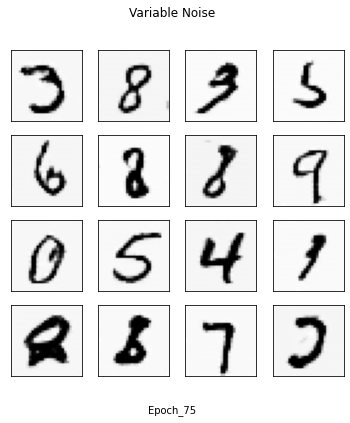

In [12]:
train(num_epochs=num_epochs,
    discriminator_net=discriminator_net,
    generator_net = generator_net,
    optimizerD = optimizerD,
    optimizerG = optimizerG,
    train_loader = train_loader,
    fake_label = fake_label,
    real_label = real_label,
    criterion = criterion,
    output_path = output_path,
    num_test_samples = num_test_samples,
    device = device)

`model.train()` tells your model that you are training the model. So effectively layers like `dropout`, `batchnorm` etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.